### 필요한 모듈 import

In [36]:
import pyupbit
import schedule
import csv
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import numpy as np

### 데이터 불러오기

In [37]:
btc = pyupbit.get_ohlcv('KRW-BTC', count=60*60*24*365*5, interval='minute5') 
btc.to_csv('btc_5min.csv')

In [38]:
#실행할 함수
def btc_update(): 
    with open('btc_5min.csv', 'w') as data:
        writer = csv.writer(data)
        new_data = pyupbit.get_ohlcv('KRW-BTC', count=1, interval='minute5') 
        writer.writerow(new_data)
            
    now = datetime.datetime.now() 
    print(f'현재시간 : {now}') 
        
#실행 주기 설정
schedule.every(5).minutes.do(btc_update)

#스케줄러 시작
while True: 
    schedule.run_pending() 
    time.sleep(1)


In [39]:
btc = pd.read_csv('btc_5min.csv')

btc

Unnamed: 0        open        high         low       close  \
0       2017-09-25 12:00:00   4201000.0   4224000.0   4195000.0   4224000.0   
1       2017-09-25 12:05:00   4225000.0   4241000.0   4208000.0   4227000.0   
2       2017-09-25 12:10:00   4215000.0   4236000.0   4212000.0   4227000.0   
3       2017-09-25 12:15:00   4227000.0   4244000.0   4210000.0   4227000.0   
4       2017-09-25 12:20:00   4215000.0   4242000.0   4203000.0   4215000.0   
...                     ...         ...         ...         ...         ...   
450343  2022-01-12 15:05:00  52083000.0  52119000.0  52021000.0  52046000.0   
450344  2022-01-12 15:10:00  52046000.0  52102000.0  52022000.0  52100000.0   
450345  2022-01-12 15:15:00  52077000.0  52102000.0  52020000.0  52024000.0   
450346  2022-01-12 15:20:00  52024000.0  52084000.0  52024000.0  52028000.0   
450347  2022-01-12 15:25:00  52029000.0  52029000.0  52023000.0  52023000.0   

           volume         value  
0        8.518420  3.585738e+07  
1        7.421608  3.137140e+07  
2        6.693031  2.826349e+07  
3        9.531738  4.027968e+07  
4        9.113169  3.846652e+07  
...           ...           ...  
450343  21.922127  1.141397e+09  
450344  10.320182  5.372223e+08  
450345   7.133648  3.712219e+08  
450346  14.217939  7.399529e+08  
450347   2.528658  1.315527e+08  

[450348 rows x 7 columns]

In [40]:
scaler = StandardScaler()

scaled = scaler.fit_transform(btc.iloc[:, 1:])

df = pd.DataFrame(scaled, columns=btc.columns[1:])

df

open      high       low     close    volume     value
0      -0.807537 -0.806809 -0.807447 -0.806452 -0.446544 -0.467166
1      -0.806400 -0.806005 -0.806831 -0.806310 -0.466335 -0.469978
2      -0.806874 -0.806241 -0.806641 -0.806310 -0.479481 -0.471926
3      -0.806306 -0.805863 -0.806736 -0.806310 -0.428260 -0.464394
4      -0.806874 -0.805958 -0.807068 -0.806878 -0.435812 -0.465530
...          ...       ...       ...       ...       ...       ...
450343  1.460590  1.458627  1.461338  1.458880 -0.204691  0.225891
450344  1.458837  1.457823  1.461386  1.461438 -0.414033 -0.152863
450345  1.460305  1.457823  1.461291  1.457838 -0.471530 -0.256928
450346  1.457795  1.456972  1.461481  1.458027 -0.343703 -0.025772
450347  1.458032  1.454370  1.461433  1.457791 -0.554622 -0.407175

[450348 rows x 6 columns]

In [41]:
features = ['open', 'high', 'low', 'volume', 'value']
target = ['close']

x = df[features]
y = df[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=False)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((360278, 5), (90070, 5), (360278, 1), (90070, 1))

In [42]:
def windowed_dataset(x, y, window_size, batch_size, shuffle):
    # X값 window dataset 구성
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, shift=1, stride=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda x: x.batch(window_size))
    # y값 추가
    ds_y = tf.data.Dataset.from_tensor_slices(y[window_size:])
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(1)

In [43]:
WINDOW_SIZE=20    #과거 20개의 데이터를 통해 예측
BATCH_SIZE=len(x)

train_data = windowed_dataset(x_train, y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(x_test, y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [44]:
model = Sequential([
    Conv1D(filters=32, kernel_size=5, activation="relu", input_shape=[WINDOW_SIZE, 5]),
    LSTM(64, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용
model.compile(loss='huber', optimizer='adam', metrics=['mse'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 16, 32)            832       
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 26,721
Trainable params: 26,721
Non-trainable params: 0
_________________________________________________________________


In [45]:
#batch_size = [32, 64, 128]
#param_grid = dict(batch_size=batch_size)

#grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
#grid_result = grid.fit(x, y) 

In [46]:
# 10번 epoch동안 val_loss의 개선이 없다면 학습을 멈춤
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

# val_loss 기준 체크포인터 생성
filename = os.path.join('tmp', 'ckeckpointer.ckpt')

checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=2)
                             
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=100, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/100
      1/Unknown - 61s 61s/step - loss: 0.1794 - mse: 0.3609
Epoch 00001: val_loss improved from inf to 0.63887, saving model to tmp\ckeckpointer.ckpt
1/1 [==============================] - 68s 68s/step - loss: 0.1794 - mse: 0.3609 - val_loss: 0.6389 - val_mse: 1.4105
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.1374 - mse: 0.2758
Epoch 00002: val_loss improved from 0.63887 to 0.47983, saving model to tmp\ckeckpointer.ckpt
1/1 [==============================] - 58s 58s/step - loss: 0.1374 - mse: 0.2758 - val_loss: 0.4798 - val_mse: 1.0151
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.1087 - mse: 0.2179
Epoch 00003: val_loss improved from 0.47983 to 0.33244, saving model to tmp\ckeckpointer.ckpt
1/1 [==============================] - 59s 59s/step - loss: 0.1087 - mse: 0.2179 - val_loss: 0.3324 - val_mse: 0.6814
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.0806 - mse: 0.1615
Epoch 00004: val_loss improved f

In [47]:
loss = round(float(min(history.history['val_loss'])), 4)
print(f'val_loss = {loss}')

model.load_weights(filename)

pred = model.predict(test_data)

actual = np.asarray(y_test)[WINDOW_SIZE:]
actual = np.reshape(actual, (len(actual), 1))

print(pred.shape)
print(actual.shape)

val_loss = 0.0207
(90050, 1)
(90050, 1)


In [48]:
model.evaluate(test_data, batch_size=128)

1/1 [==============================] - 6s 6s/step - loss: 0.0207 - mse: 0.0415


[0.020732829347252846, 0.04152277484536171]

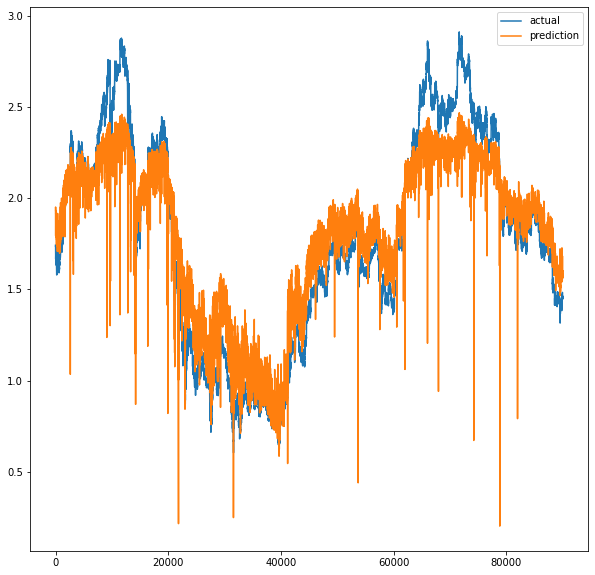

In [49]:
plt.figure(figsize=(10,10))
plt.plot(actual, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [51]:
#지금 100만원을 투자한다면 5분 뒤 수익률 예상해보기
seed_money = 1000000

origin_percent = (float(btc['close'][len(btc['close'])-1]) - float(btc['close'][WINDOW_SIZE])) / float(btc['close'][WINDOW_SIZE]) * 100
array_pred_percents = []

for indx in range(len(pred)):
    live_close = float(btc['close'][indx+WINDOW_SIZE])
    pred_close = float(pred[indx])
    pred_percent = (pred_close - live_close) / live_close * 100
    if pred_percent > 0:
        array_pred_percents.append(pred_percent)

    print("%d 현재가 %.2f ---> 5분 후 예상 가격%.2f" % (indx, live_close, pred_close), end='')
    print(" ===> 예상 수익률 %.2f%%," % (pred_percent), end='')
    
    if indx + WINDOW_SIZE + 1 < len(df['close']):
        live_percent = (float(btc['close'][indx+WINDOW_SIZE+1]) - live_close) / live_close * 100
        
        print("실제 수익률 %.2f%%  " % (live_percent))
        
    else:
        print()
        
print("코인 홀딩 시 예상 수익 : %d" % (int(seed_money + (seed_money * origin_percent / 100))))

0 현재가 4181000.00 ---> 5분 후 예상 가격1.80 ===> 예상 수익률 -100.00%,실제 수익률 0.00%  
1 현재가 4181000.00 ---> 5분 후 예상 가격1.86 ===> 예상 수익률 -100.00%,실제 수익률 0.05%  
2 현재가 4183000.00 ---> 5분 후 예상 가격1.92 ===> 예상 수익률 -100.00%,실제 수익률 0.33%  
3 현재가 4197000.00 ---> 5분 후 예상 가격1.92 ===> 예상 수익률 -100.00%,실제 수익률 -0.29%  
4 현재가 4185000.00 ---> 5분 후 예상 가격1.93 ===> 예상 수익률 -100.00%,실제 수익률 0.12%  
5 현재가 4190000.00 ---> 5분 후 예상 가격1.95 ===> 예상 수익률 -100.00%,실제 수익률 0.14%  
6 현재가 4196000.00 ---> 5분 후 예상 가격1.95 ===> 예상 수익률 -100.00%,실제 수익률 -0.21%  
7 현재가 4187000.00 ---> 5분 후 예상 가격1.95 ===> 예상 수익률 -100.00%,실제 수익률 0.12%  
8 현재가 4192000.00 ---> 5분 후 예상 가격1.93 ===> 예상 수익률 -100.00%,실제 수익률 -0.02%  
9 현재가 4191000.00 ---> 5분 후 예상 가격1.92 ===> 예상 수익률 -100.00%,실제 수익률 -0.12%  
10 현재가 4186000.00 ---> 5분 후 예상 가격1.92 ===> 예상 수익률 -100.00%,실제 수익률 0.17%  
11 현재가 4193000.00 ---> 5분 후 예상 가격1.92 ===> 예상 수익률 -100.00%,실제 수익률 -0.10%  
12 현재가 4189000.00 ---> 5분 후 예상 가격1.94 ===> 예상 수익률 -100.00%,실제 수익률 0.05%  
13 현재가 4191000.00 ---> 5분 후 예상 가격1.93 ===> 